In [ ]:
import numpy as np
from scipy.io import loadmat
from scipy.optimize import minimize

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving mnist_all.mat to mnist_all.mat


In [ ]:
def preprocess():
    mat = loadmat('mnist_all.mat')
    n_feature = mat.get("train1").shape[1]
    n_sample = 0
    for i in range(10):
        n_sample = n_sample + mat.get("train" + str(i)).shape[0]
    n_validation = 1000
    n_train = n_sample - 10 * n_validation

    # Construct validation data
    validation_data = np.zeros((10 * n_validation, n_feature))
    for i in range(10):
        validation_data[i * n_validation:(i + 1) * n_validation, :] = mat.get("train" + str(i))[0:n_validation, :]

    # Construct validation label
    validation_label = np.ones((10 * n_validation, 1))
    for i in range(10):
        validation_label[i * n_validation:(i + 1) * n_validation, :] = i * np.ones((n_validation, 1))

    # Construct training data and label
    train_data = np.zeros((n_train, n_feature))
    train_label = np.zeros((n_train, 1))
    temp = 0
    for i in range(10):
        size_i = mat.get("train" + str(i)).shape[0]
        train_data[temp:temp + size_i - n_validation, :] = mat.get("train" + str(i))[n_validation:size_i, :]
        train_label[temp:temp + size_i - n_validation, :] = i * np.ones((size_i - n_validation, 1))
        temp = temp + size_i - n_validation

    # Construct test data and label
    n_test = 0
    for i in range(10):
        n_test = n_test + mat.get("test" + str(i)).shape[0]
    test_data = np.zeros((n_test, n_feature))
    test_label = np.zeros((n_test, 1))
    temp = 0
    for i in range(10):
        size_i = mat.get("test" + str(i)).shape[0]
        test_data[temp:temp + size_i, :] = mat.get("test" + str(i))
        test_label[temp:temp + size_i, :] = i * np.ones((size_i, 1))
        temp = temp + size_i


    # Delete features which don't provide any useful information for classifiers
    sigma = np.std(train_data, axis=0)
    index = np.array([])
    for i in range(n_feature):
        if (sigma[i] > 0.001):
            index = np.append(index, [i])
    train_data = train_data[:, index.astype(int)]
    validation_data = validation_data[:, index.astype(int)]
    test_data = test_data[:, index.astype(int)]

    # Scale data to 0 and 1
    train_data /= 255.0
    validation_data /= 255.0
    test_data /= 255.0

    return train_data, train_label, validation_data, validation_label, test_data, test_label

In [ ]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def blrObjFunction(initialWeights, *args):
    train_data, labeli = args
    n_data = train_data.shape[0]
    n_features = train_data.shape[1]

    initialWeights = initialWeights.reshape((n_features + 1, 1))
    train_data = np.hstack((np.ones((n_data, 1)), train_data))
    z = np.dot(train_data, initialWeights)
    sig_data = sigmoid(z)
    sig_data = np.clip(sig_data, 1e-10, 1 - 1e-10)

    error = -np.sum(labeli * np.log(sig_data) + (1 - labeli) * np.log(1 - sig_data)) / n_data
    error_grad = -np.dot(train_data.T, (sig_data - labeli)) / n_data
    error_grad = error_grad.flatten()

    return error, error_grad

def blrPredict(W, data):
    n_data = data.shape[0]
    data = np.hstack((np.ones((n_data, 1)), data))
    probabilities = sigmoid(np.dot(data, W))
    label = np.argmax(probabilities, axis=1).reshape(-1, 1)

    return label

In [ ]:
train_data, train_label, validation_data, validation_label, test_data, test_label = preprocess()

n_class = 10
n_train = train_data.shape[0]
n_feature = train_data.shape[1]

Y = np.zeros((n_train, n_class))
for i in range(n_class):
    Y[:, i] = (train_label == i).astype(int).ravel()

W = np.zeros((n_feature + 1, n_class))
initialWeights = np.zeros((n_feature + 1))
opts = {'maxiter': 100}
for i in range(n_class):
    labeli = Y[:, i].reshape(n_train, 1)
    args = (train_data, labeli)
    nn_params = minimize(blrObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)
    W[:, i] = nn_params.x.reshape((n_feature + 1,))

In [ ]:
# Find the accuracy on Training Dataset
tr_predicted_label = blrPredict(W, train_data)
print('\n Training set Accuracy:' + str(100 * np.mean((tr_predicted_label == train_label).astype(float))) + '%')

# Find the accuracy on Validation Dataset
val_predicted_label = blrPredict(W, validation_data)
print('\n Validation set Accuracy:' + str(100 * np.mean((val_predicted_label == validation_label).astype(float))) + '%')

# Find the accuracy on Testing Dataset
te_predicted_label = blrPredict(W, test_data)
print('\n Testing set Accuracy:' + str(100 * np.mean((te_predicted_label == test_label).astype(float))) + '%')


 Training set Accuracy:9.846%

 Validation set Accuracy:10.0%

 Testing set Accuracy:9.8%


In [ ]:
# Errors for each binary pair (category)

def error_per_class(pred, actual):
    err = {}
    for i in range(n_class):
        idx = (actual.flatten() == i)
        if np.sum(idx) > 0:
            err[i] = 1 - np.mean(pred[idx] == i)
        else:
            err[i] = None
    return err

tr_err = error_per_class(tr_predicted_label, train_label)
te_err = error_per_class(te_predicted_label, test_label)

print("\nTraining Error per Class:")
for i in range(n_class):
    print(f"Class {i}: {tr_err[i]:.4f}")

print("\nTesting Error per Class:")
for i in range(n_class):
    print(f"Class {i}: {te_err[i]:.4f}")


Training Error per Class:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 1.0000
Class 3: 1.0000
Class 4: 1.0000
Class 5: 1.0000
Class 6: 1.0000
Class 7: 1.0000
Class 8: 1.0000
Class 9: 1.0000

Testing Error per Class:
Class 0: 0.0000
Class 1: 1.0000
Class 2: 1.0000
Class 3: 1.0000
Class 4: 1.0000
Class 5: 1.0000
Class 6: 1.0000
Class 7: 1.0000
Class 8: 1.0000
Class 9: 1.0000


In [ ]:
def mlrObjFunction(params, *args):
    train_data, labeli = args
    n_data = train_data.shape[0]
    n_feature = train_data.shape[1]
    n_class = labeli.shape[1]

    W = params.reshape((n_feature + 1, n_class))
    train_data = np.hstack((np.ones((n_data, 1)), train_data))
# compute softmax for the features variables
    logits_y = np.dot(train_data, W)
    logits_y -= np.max(logits_y, axis=1, keepdims=True)
    probs = np.exp(logits_y)
    probs /= np.sum(probs, axis=1, keepdims=True)

    merror = -np.sum(labeli * np.log(probs)) # to differentiate the error function above
    merror_grad = np.dot(train_data.T, (probs - labeli))  # same concern as above
    merror_grad = merror_grad.flatten()

    return merror, merror_grad

In [ ]:
# apply 1 of K encoding which is One-Hot Encoding
def mlr_ohe(label, n_class):
    return np.eye(n_class)[label.astype(int).reshape(-1)]

n_class = 10
train_label_encoded = mlr_ohe(train_label, n_class)

In [ ]:
def mlrPredict(W, data):
    n_data = data.shape[0]
    data = np.hstack((np.ones((n_data, 1)), data))
    logits_y = np.dot(data, W)
    probs = np.exp(logits_y)
    probs /= np.sum(probs, axis=1, keepdims=True)
    mlabel = np.argmax(probs, axis=1).reshape(-1, 1)

    return mlabel

In [ ]:
n_class = 10
n_train = train_data.shape[0]
n_feature = train_data.shape[1]

W_b = np.zeros((n_feature + 1, n_class))
initialWeights_b = np.zeros((n_feature + 1, n_class)).flatten()
opts_b = {'maxiter': 100}

Ym = train_label_encoded
args_b = (train_data, Ym)
nn_params_b = minimize(mlrObjFunction, initialWeights_b, jac=True, args=args_b, method='CG', options=opts_b)
W_b = nn_params_b.x.reshape((n_feature + 1, n_class))

In [ ]:
# Find the accuracy on Training Dataset
tr_predicted_label_b = mlrPredict(W_b, train_data)
print('\nMulti-Class Training set Accuracy:' + str(100 * np.mean((tr_predicted_label_b == train_label).astype(float))) + '%')

# Find the accuracy on Validation Dataset
val_predicted_label_b = mlrPredict(W_b, validation_data)
print('\n Multi-Class Validation set Accuracy:' + str(100 * np.mean((val_predicted_label_b == validation_label).astype(float))) + '%')

# Find the accuracy on Testing Dataset
te_predicted_label_b = mlrPredict(W_b, test_data)
print('\n Multi-Class Testing set Accuracy:' + str(100 * np.mean((te_predicted_label_b == test_label).astype(float))) + '%')


Multi-Class Training set Accuracy:93.16%

 Multi-Class Validation set Accuracy:92.4%

 Multi-Class Testing set Accuracy:92.55%


In [ ]:
# Errors for the Multi-Class Classification

def multi_class_error(predicted, actual):
    error = {}
    for i in range(n_class):
        idx = actual.flatten() == i
        error[i] = 1 - np.mean(predicted[idx] == i)
    return error

mtr_err = multi_class_error(tr_predicted_label_b, train_label)
mte_err = multi_class_error(te_predicted_label_b, test_label)

print("\nMulti-Class Training Error per Class:")
for i in range(n_class):
    print(f"Class {i}: {mtr_err[i]:.3f}")

print("\nMulti-Class Testing Error per Class:")
for i in range(n_class):
    print(f"Class {i}: {mte_err[i]:.3f}")


Multi-Class Training Error per Class:
Class 0: 0.028
Class 1: 0.023
Class 2: 0.086
Class 3: 0.089
Class 4: 0.060
Class 5: 0.113
Class 6: 0.038
Class 7: 0.058
Class 8: 0.114
Class 9: 0.086

Multi-Class Testing Error per Class:
Class 0: 0.016
Class 1: 0.019
Class 2: 0.099
Class 3: 0.086
Class 4: 0.064
Class 5: 0.138
Class 6: 0.049
Class 7: 0.080
Class 8: 0.123
Class 9: 0.082


In [ ]:
from sklearn import svm
from sklearn.svm import SVC
import matplotlib.pyplot as plt

In [ ]:
# .....datasets
X_train = train_data
y_train = train_label.flatten()
X_val = validation_data
y_val = validation_label.flatten()
X_test = test_data
y_test = test_label.flatten()

In [ ]:
# accuracy function
def accuracy(true_labels, predicted_labels):
    correct = np.sum(true_labels == predicted_labels)
    total = true_labels.shape[0]
    return (correct / total) * 100

In [ ]:
# SVM with Linear Kernel
clf_linear = svm.SVC(kernel='linear')
clf_linear.fit(X_train, y_train)

train_preds = clf_linear.predict(X_train)
val_preds = clf_linear.predict(X_val)
test_preds = clf_linear.predict(X_test)

print("SVM with Linear Kernel:")
print(f"Training Accuracy: {accuracy(y_train, train_preds):.2f}%")
print(f"Validation Accuracy: {accuracy(y_val, val_preds):.2f}%")
print(f"Testing Accuracy: {accuracy(y_test, test_preds):.2f}%\n")

SVM with Linear Kernel:
Training Accuracy: 97.29%
Validation Accuracy: 93.64%
Testing Accuracy: 93.78%



In [ ]:
# RBF with value gamma=1 setting
clf_rbf1 = svm.SVC(kernel='rbf', gamma=1)
clf_rbf1.fit(X_train, y_train)

train_preds_g1 = clf_rbf1.predict(X_train)
val_preds_g1 = clf_rbf1.predict(X_val)
test_preds_g1 = clf_rbf1.predict(X_test)

print("RBF Kernel with gamma=1 :")
print(f"Training Accuracy: {accuracy(y_train, train_preds_g1):.2f}%")
print(f"Validation Accuracy: {accuracy(y_val, val_preds_g1):.2f}%")
print(f"Testing Accuracy: {accuracy(y_test, test_preds_g1):.2f}%\n")

RBF Kernel with gamma=1 :
Training Accuracy: 100.00%
Validation Accuracy: 15.48%
Testing Accuracy: 17.14%



In [ ]:
# RBF with default gamma setting
clf_rbf_default = svm.SVC(kernel='rbf')
clf_rbf_default.fit(X_train, y_train)

train_preds_gd = clf_rbf_default.predict(X_train)
val_preds_gd = clf_rbf_default.predict(X_val)
test_preds_gd = clf_rbf_default.predict(X_test)

print("RBF Kernel with default gamma:")
print(f"Training Accuracy: {accuracy(y_train, train_preds_gd):.2f}%")
print(f"Validation Accuracy: {accuracy(y_val, val_preds_gd):.2f}%")
print(f"Testing Accuracy: {accuracy(y_test, test_preds_gd):.2f}%\n")

RBF Kernel with default gamma:
Training Accuracy: 98.98%
Validation Accuracy: 97.89%
Testing Accuracy: 97.87%



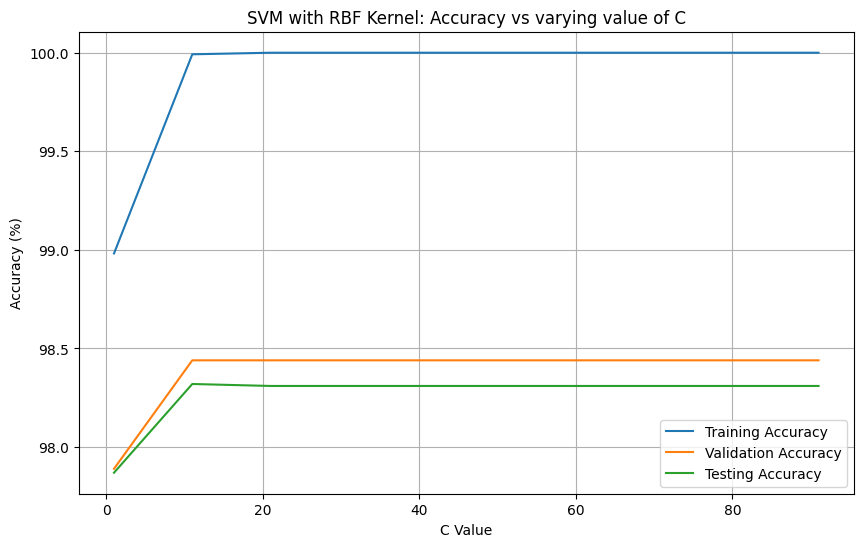

In [ ]:
# RBF with default gamma setting and varying values of C
C_values = list(range(1, 101, 10))
train_acc, val_acc, test_acc = [], [], []

for C in C_values:
    clf = svm.SVC(kernel='rbf', C=C)
    clf.fit(X_train, y_train)

    train_acc.append(accuracy(y_train, clf.predict(X_train)))
    val_acc.append(accuracy(y_val, clf.predict(X_val)))
    test_acc.append(accuracy(y_test, clf.predict(X_test)))

plt.figure(figsize=(10, 6))
plt.plot(C_values, train_acc, label="Training Accuracy")
plt.plot(C_values, val_acc, label="Validation Accuracy")
plt.plot(C_values, test_acc, label="Testing Accuracy")
plt.xlabel("C Value")
plt.ylabel("Accuracy (%)")
plt.title("SVM with RBF Kernel: Accuracy vs varying value of C")
plt.legend()
plt.grid(True)
plt.show()